In [13]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import random

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import glob
import os
from datetime import datetime

import tensorflow as tf

In [14]:
gpus = tf.config.experimental.list_physical_devices('GPU')

In [27]:
now = datetime.now()

#TRAIN_IMG_SRC_FOLDER = '/./lung-segmentation/uniq'
# FOLDER_TEST = "3D-views-script"
FOLDER_TEST = "axis_images_tf12_black"
TRAIN_IMG_SRC_FOLDER = "/home/guilherme/Documents/noa/cidia19/data/3d-input/" + FOLDER_TEST
LIST_IMG_FOLDERS = ["exame1", "exame6", "exame11", "exame12", 
                    "exame2", "exame7", "exame13", "exame14", 
                    "exame3", "exame8", "exame15", "exame16", 
                    "exame4", "exame9", "exame17", "exame18", 
                    "exame5", "exame10", "exame19", "exame20", "exame21"]
TRAIN_IMG_FOLDERS = {
    "exame1": "healthy", # 0
    "exame6": "others",  # 0
    "exame11": "covid",
    "exame12": "covid",
    "exame2": "healthy", # 1
    "exame7": "others",
    "exame13": "covid",
    "exame14": "covid",
    "exame3": "healthy", # 2
    "exame8": "others",
    "exame15": "covid",
    "exame16": "covid",
    "exame4": "healthy", # 3
    "exame9": "others",
    "exame17": "covid",
    "exame18": "covid",
    "exame5": "healthy", # 4
    "exame10": "others",
    "exame19": "covid",
    "exame20": "covid",
    "exame21": "covid"
}

VALIDATION_IMG_SRC_FOLDER = "/home/guilherme/Documents/noa/cidia19/data/3d-input/" + FOLDER_TEST
VALIDATION_IMG_FOLDERS = {
#     "exame5": "healthy",
#     "exame15": "covid",
#     "exame10": "others"
}
SUB_FILE = ['axis1', 'axis2', 'axis3', 'axis4']

# EXAM_SLICE = 200
CLASSES = len(set([label for label in TRAIN_IMG_FOLDERS.values()]))
EPOCHS = 50
IMG_HEIGHT = 200
IMG_WIDTH = 200
IMG_CHANNELS = 3
SELECTED_MODEL = 'simple'

In [28]:
def get_file_path(folder, search_filter=''):
    paths = []
    for root, dirs, files in os.walk(folder):
        for file in files:
            path = os.path.join(root, file)
            if search_filter in path:
                paths.append(path)
    return paths

def get_data_set(set_number, cur_subfile):
    dfs = []
    train_images = {"id": [], "label": []}
    validation_images = {"id": [], "label": []}
    subset_imgs_folder_val = LIST_IMG_FOLDERS[set_number * 4:(set_number+1) * 4]
    
    TRAIN_IMG_FOLDERS_SLICE = {}
    for img_folder in LIST_IMG_FOLDERS:
        if img_folder not in subset_imgs_folder_val:
            TRAIN_IMG_FOLDERS_SLICE[img_folder] = TRAIN_IMG_FOLDERS[img_folder]
        
    VALIDATION_IMG_FOLDERS_SLICE = {}
    for img_folder in subset_imgs_folder_val:
        VALIDATION_IMG_FOLDERS_SLICE[img_folder] = TRAIN_IMG_FOLDERS[img_folder]
    
#     print(TRAIN_IMG_FOLDERS_SLICE)
#     print(VALIDATION_IMG_FOLDERS_SLICE)
    
    df_config = [
        (TRAIN_IMG_SRC_FOLDER, TRAIN_IMG_FOLDERS_SLICE, train_images),
        (VALIDATION_IMG_SRC_FOLDER, VALIDATION_IMG_FOLDERS_SLICE, validation_images)
    ]
    for (base, folder, dic) in df_config:
        for img_folder, img_label in folder.items():
            search_folder = "{}/{}".format(base, img_folder)
            imgs_filename = sorted(get_file_path(search_folder, search_filter = cur_subfile))
            dic["id"].extend(imgs_filename)
            dic["label"].extend([img_label] * len(imgs_filename))

        dfs.append(pd.DataFrame(data=dic))

    train_df, validation_df = dfs[0], dfs[1]

    train_df.to_csv('train_df_'+str(set_number)+'.csv', index=False)
    validation_df.to_csv('validation_df_'+str(set_number)+'.csv', index=False)

    print("Train fold with {} images".format(len(train_df)))
    print(train_df.groupby("label").label.count())
    print()
    print("Validation fold with {} images".format(len(validation_df)))
    print(validation_df.groupby("label").label.count())
    print("-" * 30)
    return (train_df, validation_df)

In [29]:
def get_side(img, side_type, side_size=5):
    height, width, channel=img.shape
    if side_type=="horizontal":
        return np.ones((height,side_size,  channel), dtype=np.float32)*255
        
    return np.ones((side_size, width,  channel), dtype=np.float32)*255

def show_gallery(show="all"):
    n=100
    counter=0
    images=list()
    vertical_images=[]
    rng_state = np.random.get_state()
    np.random.shuffle(train_images["id"])
    np.random.set_state(rng_state)
    np.random.shuffle(train_images["label"])
    for path, target in zip(train_images["id"], train_images["label"]):
        if target!=show and show!="all":
            continue
        counter=counter+1
        if counter%100==0:
            break
        #Image loading from disk as JpegImageFile file format
        img=load_img(path, target_size=(IMG_WIDTH,IMG_HEIGHT))
        #Converting JpegImageFile to numpy array
        img=img_to_array(img)
        
        hside=get_side(img, side_type="horizontal")
        images.append(img)
        images.append(hside)

        if counter%10==0:
            himage=np.hstack((images))
            vside=get_side(himage, side_type="vertical")
            vertical_images.append(himage)
            vertical_images.append(vside)
            
            images=list()

    gallery=np.vstack((vertical_images)) 
    plt.figure(figsize=(12,12))
    plt.xticks([])
    plt.yticks([])
    title = {"all":"All Classifications's",
             "healthy":"Healthy",
             "covid":"Covid-19"}
    plt.title("100 Samples of {} Patients of the training set".format(title[show]))
    plt.imshow(gallery.astype(np.uint8))


In [30]:
#show_gallery("all")

In [31]:
def get_data_generator(dataframe, x_col, y_col, subset=None, shuffle=True, batch_size=32, class_mode="binary"):
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.05,
    horizontal_flip=False,
    width_shift_range=0.1,
    height_shift_range=0.1,
#     fill_mode='constant',
#     cval=0
    )
    
    data_generator = datagen.flow_from_dataframe(
        dataframe=dataframe,
        x_col=x_col,
        y_col=y_col,
        subset=subset,
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        class_mode=class_mode,
        # color_mode="rgb",
        batch_size=batch_size,
        shuffle=shuffle
    )
    return data_generator

Train fold with 1870 images
label
covid      990
healthy    440
others     440
Name: label, dtype: int64

Validation fold with 440 images
label
covid      220
healthy    110
others     110
Name: label, dtype: int64
------------------------------
Found 1 validated image filenames belonging to 1 classes.


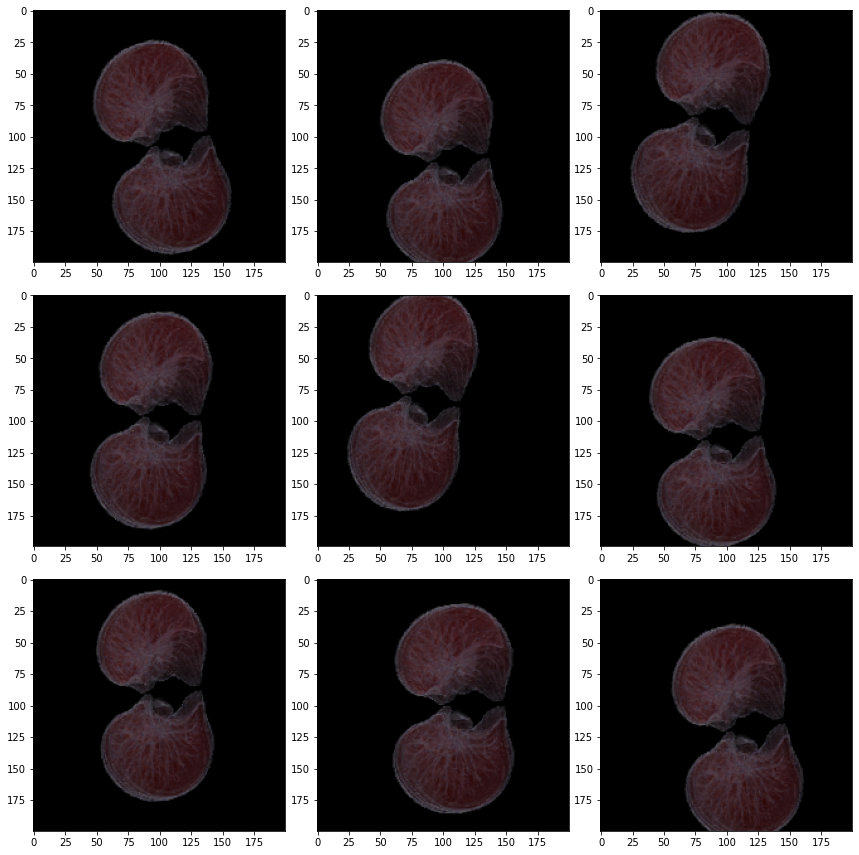

In [37]:
train_df, validation_df = get_data_set(0, SUB_FILE[0])
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = get_data_generator(example_df, "id", "label", class_mode = "categorical")
plt.figure(figsize = (12,12))
for i in range(0, 9):
        plt.subplot(3, 3, i+1)
        for X_batch, Y_batch in example_generator:
            image = X_batch[0]
            plt.imshow(image)
            break
plt.tight_layout()
plt.show()

In [38]:
def get_model():
    with tf.device('/GPU:0'):
#         inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
#         s = tf.keras.layers.Lambda(lambda x: x/255)(inputs)
        
        classifier = tf.keras.Sequential()

        classifier.add(tf.keras.layers.Conv2D(32, (3, 3), input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), activation= 'relu'))
        classifier.add(tf.keras.layers.MaxPooling2D((2, 2)))
#         classifier.add(MaxPooling2D(pool_size= (2,2)))

#         classifier.add(Convolution2D(64, (3, 3), activation= 'relu'))
        classifier.add(tf.keras.layers.Conv2D(64, (3, 3), activation= 'relu'))
        classifier.add(tf.keras.layers.MaxPooling2D((2, 2)))

        classifier.add(tf.keras.layers.Conv2D(128, (3, 3), activation= 'relu'))
        classifier.add(tf.keras.layers.MaxPooling2D((2, 2)))

        classifier.add(tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'))
        classifier.add(tf.keras.layers.MaxPooling2D((2, 2)))

        classifier.add(tf.keras.layers.Conv2D(256, (3,3), activation = 'relu'))
        classifier.add(tf.keras.layers.MaxPooling2D((2, 2)))

        classifier.add(tf.keras.layers.Flatten())

        classifier.add(tf.keras.layers.Dense(units= 512, activation= 'relu'))
        classifier.add(tf.keras.layers.Dropout(0.2))
        classifier.add(tf.keras.layers.Dense(units= 3, activation= 'sigmoid'))

        classifier.compile(optimizer= 'adam', loss= 'categorical_crossentropy' ,metrics= ['accuracy'])
        classifier.summary()

        return(classifier, 'simple')

In [39]:
def get_model_alexnet():
    with tf.device('/GPU:0'):
        model = tf.keras.Sequential()

        model.add(tf.keras.layers.Conv2D(96, kernel_size=(11,11), strides= 4, padding= 'valid', activation= 'relu', 
                                         input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), kernel_initializer= 'he_normal'))
        
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides= (2,2), padding= 'valid', 
                                               data_format= None))

        model.add(tf.keras.layers.Conv2D(256, kernel_size=(5,5), strides= 1, padding= 'same', activation= 'relu',
                                         kernel_initializer= 'he_normal'))
        
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides= (2,2), padding= 'valid', 
                                               data_format= None)) 

        model.add(tf.keras.layers.Conv2D(384, kernel_size=(3,3), strides= 1, padding= 'same', activation= 'relu',
                                         kernel_initializer= 'he_normal'))

        model.add(tf.keras.layers.Conv2D(384, kernel_size=(3,3), strides= 1, padding= 'same', activation= 'relu',
                                         kernel_initializer= 'he_normal'))

        model.add(tf.keras.layers.Conv2D(256, kernel_size=(3,3), strides= 1, padding= 'same', activation= 'relu',
                                         kernel_initializer= 'he_normal'))

        model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides= (2,2), padding= 'valid', 
                                               data_format= None))

        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(4096, activation= 'relu'))
        model.add(tf.keras.layers.Dense(4096, activation= 'relu'))
        model.add(tf.keras.layers.Dense(1000, activation= 'relu'))
        model.add(tf.keras.layers.Dense(units=3, activation= 'softmax'))

        model.compile(optimizer= tf.keras.optimizers.Adam(0.001), loss='categorical_crossentropy', 
                      metrics=['accuracy'])
        
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        model.summary()
        return(model, 'alexnet')

In [40]:
def get_model_vgg16():
        with tf.device('/GPU:0'):
            conv_base = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

            conv_base.trainable = True
            set_trainable = False
            for layer in conv_base.layers:
                if layer.name == 'conv3_block1_1_conv':
                    set_trainable = True
                if set_trainable:
                    layer.trainable = True
                else:
                    layer.trainable = False

            model = tf.keras.Sequential()
            model.add(conv_base)
            model.add(tf.keras.layers.GlobalAveragePooling2D())
            model.add(tf.keras.layers.Dense(units=3, activation = 'sigmoid'))

            model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
            model.summary()
            return (model, 'vgg16')

In [41]:
def train_model(model, train_df, validation_df, epochs, callbacks=[]):
    batch_size = 16
    train_generator = get_data_generator(train_df, "id", "label", batch_size=batch_size, class_mode="categorical")
    validation_generator = get_data_generator(validation_df, "id", "label", batch_size=batch_size, class_mode="categorical")

    step_size_train = train_generator.n // train_generator.batch_size
    step_size_validation = validation_generator.n // validation_generator.batch_size

    if step_size_train == 0:
        step_size_train = train_generator.n // 2
        step_size_validation = validation_generator.n // 2
        
    history = model.fit(train_generator, # X_Train
        steps_per_epoch=step_size_train,
        epochs=epochs, 
        validation_data=validation_generator,
        validation_steps=step_size_validation,
        callbacks=callbacks
   )
    return history.history

In [42]:

def plot_results(history, sub_folder, kfold, sel_model):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']

    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and Validation accuracy')
    plt.legend()
    plt.savefig('images/' + FOLDER_TEST + '/' + sub_folder + '/' + kfold + 'acc_'  + sel_model,
                pad_inches=0.1)
    
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()
    
    plt.savefig('images/' + FOLDER_TEST + '/' + sub_folder + '/' + kfold + 'loss_'  + sel_model, 
                orientation='portrait', pad_inches=0.1)

    plt.show()




TEST #
=====
axis1 0
Train fold with 1870 images
label
covid      990
healthy    440
others     440
Name: label, dtype: int64

Validation fold with 440 images
label
covid      220
healthy    110
others     110
Name: label, dtype: int64
------------------------------
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_100 (Conv2D)          (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_100 (MaxPoolin (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_101 (MaxPoolin (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 46, 46, 128

116/116 [==============================] - 19s 167ms/step - loss: 1.1632e-04 - accuracy: 1.0000 - val_loss: 4.3940 - val_accuracy: 0.6667
Epoch 40/50
116/116 [==============================] - 19s 167ms/step - loss: 2.3690e-05 - accuracy: 1.0000 - val_loss: 4.4376 - val_accuracy: 0.6644
Epoch 41/50
116/116 [==============================] - 19s 167ms/step - loss: 1.4138e-04 - accuracy: 1.0000 - val_loss: 4.5634 - val_accuracy: 0.6366
Epoch 42/50
116/116 [==============================] - 19s 168ms/step - loss: 7.5300e-05 - accuracy: 1.0000 - val_loss: 4.4594 - val_accuracy: 0.6597
Epoch 43/50
116/116 [==============================] - 19s 167ms/step - loss: 1.6688e-05 - accuracy: 1.0000 - val_loss: 4.3488 - val_accuracy: 0.6759
Epoch 44/50
116/116 [==============================] - 19s 168ms/step - loss: 6.9711e-05 - accuracy: 1.0000 - val_loss: 4.4284 - val_accuracy: 0.6667
Epoch 45/50
116/116 [==============================] - 19s 168ms/step - loss: 3.3057e-04 - accuracy: 1.0000 - va

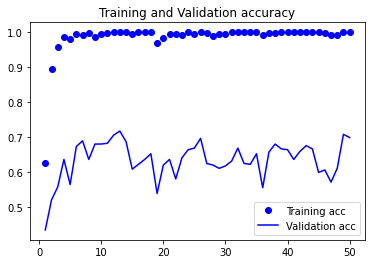

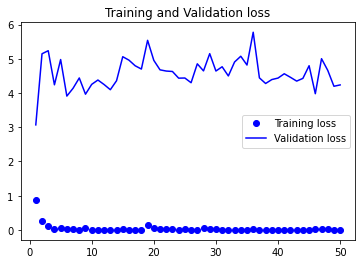




TEST #
=====
axis1 1
Train fold with 1870 images
label
covid      990
healthy    440
others     440
Name: label, dtype: int64

Validation fold with 440 images
label
covid      220
healthy    110
others     110
Name: label, dtype: int64
------------------------------
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_105 (Conv2D)          (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_105 (MaxPoolin (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_106 (MaxPoolin (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 46, 46, 128

Epoch 39/50
116/116 [==============================] - 19s 167ms/step - loss: 0.1180 - accuracy: 0.9720 - val_loss: 0.1545 - val_accuracy: 0.9444
Epoch 40/50
116/116 [==============================] - 19s 167ms/step - loss: 0.1391 - accuracy: 0.9784 - val_loss: 5.8203 - val_accuracy: 0.5231
Epoch 41/50
116/116 [==============================] - 19s 167ms/step - loss: 0.0285 - accuracy: 0.9924 - val_loss: 0.2562 - val_accuracy: 0.9352
Epoch 42/50
116/116 [==============================] - 19s 167ms/step - loss: 0.0098 - accuracy: 0.9978 - val_loss: 0.2521 - val_accuracy: 0.9236
Epoch 43/50
116/116 [==============================] - 19s 167ms/step - loss: 5.7056e-04 - accuracy: 1.0000 - val_loss: 0.0834 - val_accuracy: 0.9769
Epoch 44/50
116/116 [==============================] - 19s 167ms/step - loss: 2.7677e-05 - accuracy: 1.0000 - val_loss: 0.0714 - val_accuracy: 0.9838
Epoch 45/50
116/116 [==============================] - 19s 167ms/step - loss: 6.3960e-05 - accuracy: 1.0000 - val_lo

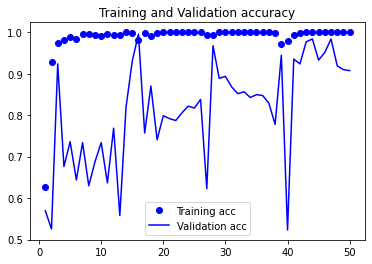

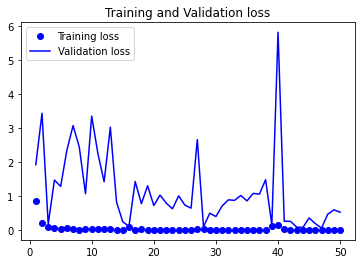




TEST #
=====
axis1 2
Train fold with 1870 images
label
covid      990
healthy    440
others     440
Name: label, dtype: int64

Validation fold with 440 images
label
covid      220
healthy    110
others     110
Name: label, dtype: int64
------------------------------
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_110 (Conv2D)          (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_110 (MaxPoolin (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_111 (Conv2D)          (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_111 (MaxPoolin (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_112 (Conv2D)          (None, 46, 46, 128

116/116 [==============================] - 19s 167ms/step - loss: 1.1271e-04 - accuracy: 1.0000 - val_loss: 2.7418 - val_accuracy: 0.7477
Epoch 40/50
116/116 [==============================] - 19s 167ms/step - loss: 6.2394e-06 - accuracy: 1.0000 - val_loss: 2.9993 - val_accuracy: 0.7407
Epoch 41/50
116/116 [==============================] - 19s 167ms/step - loss: 2.5241e-04 - accuracy: 1.0000 - val_loss: 3.0519 - val_accuracy: 0.7037
Epoch 42/50
116/116 [==============================] - 19s 167ms/step - loss: 7.8240e-05 - accuracy: 1.0000 - val_loss: 2.5965 - val_accuracy: 0.7431
Epoch 43/50
116/116 [==============================] - 19s 167ms/step - loss: 0.0197 - accuracy: 0.9968 - val_loss: 4.3191 - val_accuracy: 0.6944
Epoch 44/50
116/116 [==============================] - 19s 167ms/step - loss: 0.0397 - accuracy: 0.9908 - val_loss: 3.8805 - val_accuracy: 0.7130
Epoch 45/50
116/116 [==============================] - 19s 167ms/step - loss: 0.0260 - accuracy: 0.9941 - val_loss: 3.80

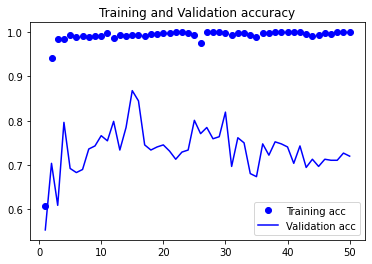

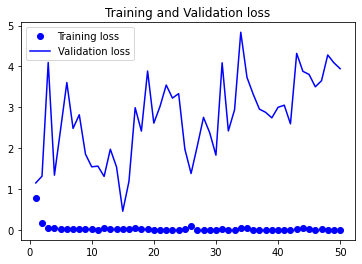




TEST #
=====
axis1 3
Train fold with 1870 images
label
covid      990
healthy    440
others     440
Name: label, dtype: int64

Validation fold with 440 images
label
covid      220
healthy    110
others     110
Name: label, dtype: int64
------------------------------
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_115 (Conv2D)          (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_115 (MaxPoolin (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_116 (Conv2D)          (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_116 (MaxPoolin (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_117 (Conv2D)          (None, 46, 46, 128

Epoch 39/50
116/116 [==============================] - 19s 167ms/step - loss: 0.0457 - accuracy: 0.9865 - val_loss: 0.6892 - val_accuracy: 0.7801
Epoch 40/50
116/116 [==============================] - 19s 167ms/step - loss: 0.0511 - accuracy: 0.9854 - val_loss: 0.9466 - val_accuracy: 0.9028
Epoch 41/50
116/116 [==============================] - 19s 167ms/step - loss: 0.0518 - accuracy: 0.9865 - val_loss: 1.9126 - val_accuracy: 0.7963
Epoch 42/50
116/116 [==============================] - 19s 167ms/step - loss: 0.0478 - accuracy: 0.9919 - val_loss: 0.9922 - val_accuracy: 0.8171
Epoch 43/50
116/116 [==============================] - 19s 167ms/step - loss: 0.0094 - accuracy: 0.9973 - val_loss: 2.4841 - val_accuracy: 0.7940
Epoch 44/50
116/116 [==============================] - 19s 167ms/step - loss: 0.0401 - accuracy: 0.9930 - val_loss: 1.9459 - val_accuracy: 0.7778
Epoch 45/50
116/116 [==============================] - 19s 168ms/step - loss: 0.0048 - accuracy: 0.9989 - val_loss: 1.2426 -

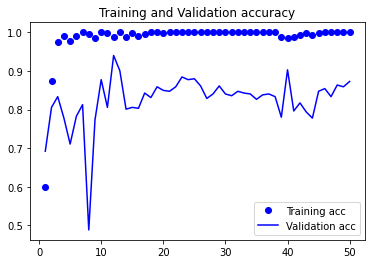

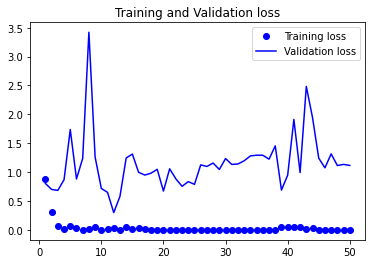




TEST #
=====
axis1 4
Train fold with 1870 images
label
covid      990
healthy    440
others     440
Name: label, dtype: int64

Validation fold with 440 images
label
covid      220
healthy    110
others     110
Name: label, dtype: int64
------------------------------
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_120 (Conv2D)          (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_120 (MaxPoolin (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_121 (MaxPoolin (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 46, 46, 128

116/116 [==============================] - 19s 166ms/step - loss: 3.6389e-06 - accuracy: 1.0000 - val_loss: 2.0513 - val_accuracy: 0.7361
Epoch 40/50
116/116 [==============================] - 19s 166ms/step - loss: 1.6924e-06 - accuracy: 1.0000 - val_loss: 2.0414 - val_accuracy: 0.7593
Epoch 41/50
116/116 [==============================] - 19s 166ms/step - loss: 9.8638e-05 - accuracy: 1.0000 - val_loss: 3.5617 - val_accuracy: 0.6181
Epoch 42/50
116/116 [==============================] - 19s 167ms/step - loss: 2.1624e-06 - accuracy: 1.0000 - val_loss: 4.1077 - val_accuracy: 0.5949
Epoch 43/50
116/116 [==============================] - 19s 167ms/step - loss: 0.0015 - accuracy: 0.9995 - val_loss: 3.2149 - val_accuracy: 0.7292
Epoch 44/50
116/116 [==============================] - 19s 167ms/step - loss: 0.0810 - accuracy: 0.9865 - val_loss: 0.6656 - val_accuracy: 0.8218
Epoch 45/50
116/116 [==============================] - 19s 166ms/step - loss: 0.0014 - accuracy: 0.9995 - val_loss: 1.51

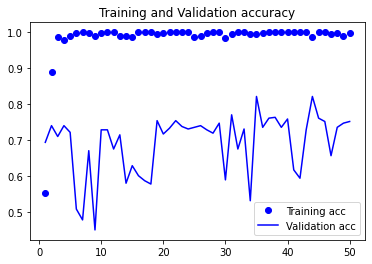

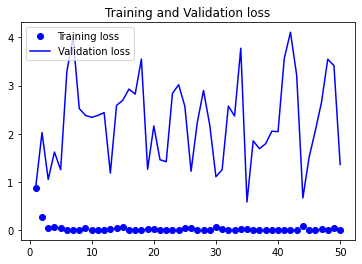




TEST #
=====
axis2 0
Train fold with 1870 images
label
covid      990
healthy    440
others     440
Name: label, dtype: int64

Validation fold with 440 images
label
covid      220
healthy    110
others     110
Name: label, dtype: int64
------------------------------
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_125 (Conv2D)          (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_125 (MaxPoolin (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_126 (Conv2D)          (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_126 (MaxPoolin (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_127 (Conv2D)          (None, 46, 46, 128

116/116 [==============================] - 20s 174ms/step - loss: 1.1271e-05 - accuracy: 1.0000 - val_loss: 4.7186 - val_accuracy: 0.6713
Epoch 40/50
116/116 [==============================] - 20s 174ms/step - loss: 4.9547e-05 - accuracy: 1.0000 - val_loss: 4.3811 - val_accuracy: 0.7106
Epoch 41/50
116/116 [==============================] - 20s 175ms/step - loss: 0.0166 - accuracy: 0.9951 - val_loss: 4.3982 - val_accuracy: 0.6829
Epoch 42/50
116/116 [==============================] - 20s 175ms/step - loss: 0.0014 - accuracy: 0.9995 - val_loss: 4.2078 - val_accuracy: 0.7153
Epoch 43/50
116/116 [==============================] - 20s 175ms/step - loss: 3.0714e-05 - accuracy: 1.0000 - val_loss: 4.2862 - val_accuracy: 0.7130
Epoch 44/50
116/116 [==============================] - 20s 174ms/step - loss: 0.0054 - accuracy: 0.9984 - val_loss: 5.0775 - val_accuracy: 0.5509
Epoch 45/50
116/116 [==============================] - 20s 174ms/step - loss: 0.0013 - accuracy: 0.9995 - val_loss: 5.4664 -

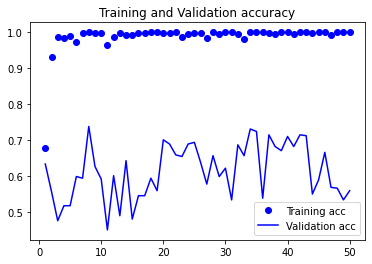

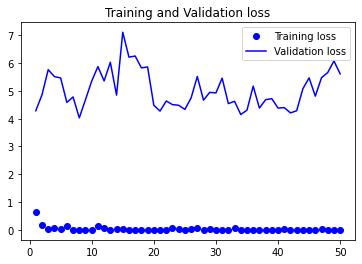




TEST #
=====
axis2 1
Train fold with 1870 images
label
covid      990
healthy    440
others     440
Name: label, dtype: int64

Validation fold with 440 images
label
covid      220
healthy    110
others     110
Name: label, dtype: int64
------------------------------
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_130 (Conv2D)          (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_130 (MaxPoolin (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_131 (Conv2D)          (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_131 (MaxPoolin (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_132 (Conv2D)          (None, 46, 46, 128

Epoch 39/50
116/116 [==============================] - 20s 174ms/step - loss: 4.3044e-05 - accuracy: 1.0000 - val_loss: 2.8742 - val_accuracy: 0.5880
Epoch 40/50
116/116 [==============================] - 20s 174ms/step - loss: 2.9573e-06 - accuracy: 1.0000 - val_loss: 3.1886 - val_accuracy: 0.5625
Epoch 41/50
116/116 [==============================] - 20s 174ms/step - loss: 1.7450e-06 - accuracy: 1.0000 - val_loss: 3.4588 - val_accuracy: 0.5463
Epoch 42/50
116/116 [==============================] - 20s 174ms/step - loss: 0.0092 - accuracy: 0.9973 - val_loss: 3.4278 - val_accuracy: 0.6597
Epoch 43/50
116/116 [==============================] - 20s 174ms/step - loss: 0.0020 - accuracy: 0.9989 - val_loss: 5.5419 - val_accuracy: 0.4653
Epoch 44/50
116/116 [==============================] - 20s 174ms/step - loss: 4.9929e-05 - accuracy: 1.0000 - val_loss: 5.5943 - val_accuracy: 0.4282
Epoch 45/50
116/116 [==============================] - 20s 174ms/step - loss: 0.0074 - accuracy: 0.9978 - va

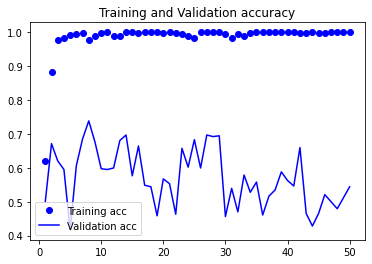

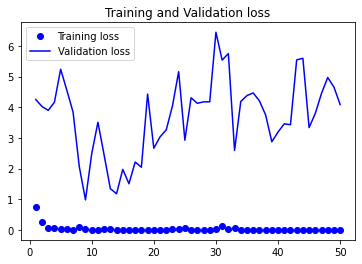




TEST #
=====
axis2 2
Train fold with 1870 images
label
covid      990
healthy    440
others     440
Name: label, dtype: int64

Validation fold with 440 images
label
covid      220
healthy    110
others     110
Name: label, dtype: int64
------------------------------
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_135 (Conv2D)          (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_135 (MaxPoolin (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_136 (Conv2D)          (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_136 (MaxPoolin (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_137 (Conv2D)          (None, 46, 46, 128

Epoch 39/50
116/116 [==============================] - 20s 174ms/step - loss: 3.1860e-05 - accuracy: 1.0000 - val_loss: 4.3859 - val_accuracy: 0.7130
Epoch 40/50
116/116 [==============================] - 20s 175ms/step - loss: 1.4820e-05 - accuracy: 1.0000 - val_loss: 4.2708 - val_accuracy: 0.7176
Epoch 41/50
116/116 [==============================] - 20s 175ms/step - loss: 3.6469e-06 - accuracy: 1.0000 - val_loss: 4.0446 - val_accuracy: 0.7361
Epoch 42/50
116/116 [==============================] - 20s 174ms/step - loss: 1.6259e-05 - accuracy: 1.0000 - val_loss: 4.2402 - val_accuracy: 0.7176
Epoch 43/50
116/116 [==============================] - 20s 174ms/step - loss: 1.4830e-05 - accuracy: 1.0000 - val_loss: 4.1626 - val_accuracy: 0.7245
Epoch 44/50
116/116 [==============================] - 20s 174ms/step - loss: 1.0445e-05 - accuracy: 1.0000 - val_loss: 4.1606 - val_accuracy: 0.7338
Epoch 45/50
116/116 [==============================] - 20s 175ms/step - loss: 7.3085e-07 - accuracy:

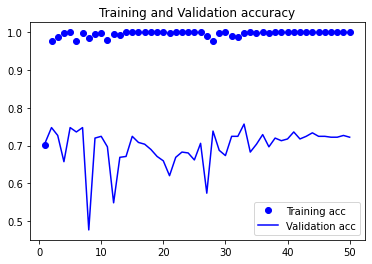

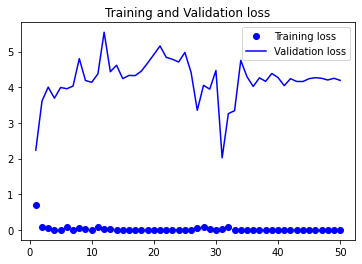




TEST #
=====
axis2 3
Train fold with 1870 images
label
covid      990
healthy    440
others     440
Name: label, dtype: int64

Validation fold with 440 images
label
covid      220
healthy    110
others     110
Name: label, dtype: int64
------------------------------
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_140 (Conv2D)          (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_140 (MaxPoolin (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_141 (Conv2D)          (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_141 (MaxPoolin (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_142 (Conv2D)          (None, 46, 46, 128

116/116 [==============================] - 20s 175ms/step - loss: 0.0412 - accuracy: 0.9423 - val_loss: 0.8177 - val_accuracy: 0.9028
Epoch 40/50
116/116 [==============================] - 20s 175ms/step - loss: 0.0409 - accuracy: 0.9423 - val_loss: 0.6510 - val_accuracy: 0.9352
Epoch 41/50
116/116 [==============================] - 20s 175ms/step - loss: 0.0415 - accuracy: 0.9428 - val_loss: 0.6239 - val_accuracy: 0.9144
Epoch 42/50
116/116 [==============================] - 20s 175ms/step - loss: 0.0408 - accuracy: 0.9423 - val_loss: 0.6102 - val_accuracy: 0.9236
Epoch 43/50
116/116 [==============================] - 20s 175ms/step - loss: 0.0423 - accuracy: 0.9488 - val_loss: 0.6804 - val_accuracy: 0.9259
Epoch 44/50
116/116 [==============================] - 20s 175ms/step - loss: 0.2043 - accuracy: 0.9083 - val_loss: 0.4543 - val_accuracy: 0.9468
Epoch 45/50
116/116 [==============================] - 20s 176ms/step - loss: 0.0975 - accuracy: 0.9391 - val_loss: 0.9832 - val_accurac

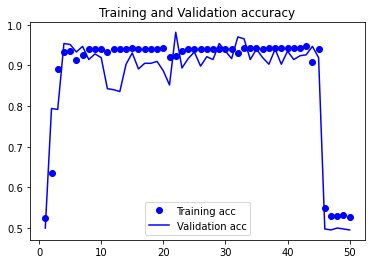

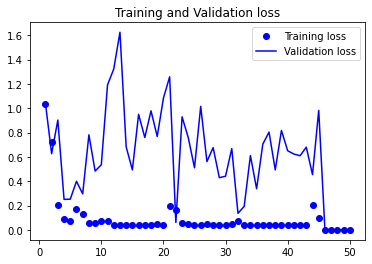




TEST #
=====
axis2 4
Train fold with 1870 images
label
covid      990
healthy    440
others     440
Name: label, dtype: int64

Validation fold with 440 images
label
covid      220
healthy    110
others     110
Name: label, dtype: int64
------------------------------
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_145 (Conv2D)          (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_145 (MaxPoolin (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_146 (Conv2D)          (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_146 (MaxPoolin (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_147 (Conv2D)          (None, 46, 46, 128

Epoch 39/50
116/116 [==============================] - 20s 175ms/step - loss: 0.0178 - accuracy: 0.9957 - val_loss: 8.3628 - val_accuracy: 0.3310
Epoch 40/50
116/116 [==============================] - 20s 175ms/step - loss: 0.0503 - accuracy: 0.9914 - val_loss: 6.6328 - val_accuracy: 0.5208
Epoch 41/50
116/116 [==============================] - 20s 175ms/step - loss: 3.9730e-04 - accuracy: 1.0000 - val_loss: 5.8785 - val_accuracy: 0.5972
Epoch 42/50
116/116 [==============================] - 20s 175ms/step - loss: 4.7840e-04 - accuracy: 1.0000 - val_loss: 7.1369 - val_accuracy: 0.5185
Epoch 43/50
116/116 [==============================] - 20s 175ms/step - loss: 0.0626 - accuracy: 0.9957 - val_loss: 9.5342 - val_accuracy: 0.3750
Epoch 44/50
116/116 [==============================] - 20s 175ms/step - loss: 0.3592 - accuracy: 0.9531 - val_loss: 5.5427 - val_accuracy: 0.4954
Epoch 45/50
116/116 [==============================] - 20s 175ms/step - loss: 3.5399e-04 - accuracy: 1.0000 - val_lo

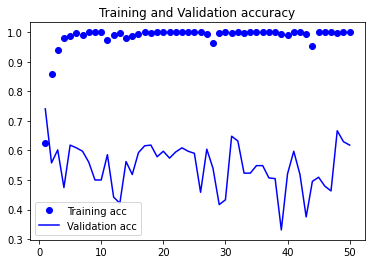

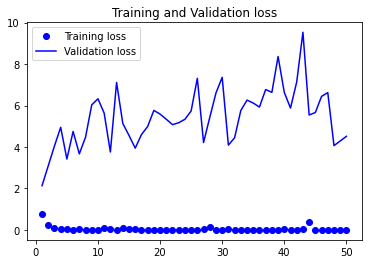




TEST #
=====
axis3 0
Train fold with 1870 images
label
covid      990
healthy    440
others     440
Name: label, dtype: int64

Validation fold with 440 images
label
covid      220
healthy    110
others     110
Name: label, dtype: int64
------------------------------
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_150 (Conv2D)          (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_150 (MaxPoolin (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_151 (Conv2D)          (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_151 (MaxPoolin (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_152 (Conv2D)          (None, 46, 46, 128

116/116 [==============================] - 20s 171ms/step - loss: 0.0137 - accuracy: 0.9978 - val_loss: 3.5872 - val_accuracy: 0.7477
Epoch 40/50
116/116 [==============================] - 20s 171ms/step - loss: 0.0069 - accuracy: 0.9968 - val_loss: 1.7669 - val_accuracy: 0.7338
Epoch 41/50
116/116 [==============================] - 20s 171ms/step - loss: 0.0139 - accuracy: 0.9957 - val_loss: 3.6026 - val_accuracy: 0.7546
Epoch 42/50
116/116 [==============================] - 20s 170ms/step - loss: 0.0020 - accuracy: 0.9995 - val_loss: 3.3503 - val_accuracy: 0.7477
Epoch 43/50
116/116 [==============================] - 20s 171ms/step - loss: 1.9643e-05 - accuracy: 1.0000 - val_loss: 3.5536 - val_accuracy: 0.7454
Epoch 44/50
116/116 [==============================] - 20s 171ms/step - loss: 4.6176e-05 - accuracy: 1.0000 - val_loss: 3.3047 - val_accuracy: 0.7500
Epoch 45/50
116/116 [==============================] - 20s 171ms/step - loss: 8.9756e-05 - accuracy: 1.0000 - val_loss: 3.6741 -

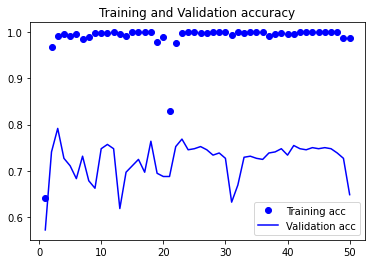

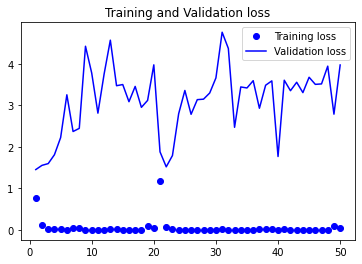




TEST #
=====
axis3 1
Train fold with 1870 images
label
covid      990
healthy    440
others     440
Name: label, dtype: int64

Validation fold with 440 images
label
covid      220
healthy    110
others     110
Name: label, dtype: int64
------------------------------
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_155 (Conv2D)          (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_155 (MaxPoolin (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_156 (Conv2D)          (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_156 (MaxPoolin (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_157 (Conv2D)          (None, 46, 46, 128

116/116 [==============================] - 20s 171ms/step - loss: 0.0506 - accuracy: 0.9903 - val_loss: 2.4228 - val_accuracy: 0.7407
Epoch 40/50
116/116 [==============================] - 20s 170ms/step - loss: 0.0231 - accuracy: 0.9941 - val_loss: 0.4749 - val_accuracy: 0.8750
Epoch 41/50
116/116 [==============================] - 20s 171ms/step - loss: 0.0162 - accuracy: 0.9957 - val_loss: 2.9034 - val_accuracy: 0.6597
Epoch 42/50
116/116 [==============================] - 20s 170ms/step - loss: 0.0144 - accuracy: 0.9973 - val_loss: 2.0430 - val_accuracy: 0.8287
Epoch 43/50
116/116 [==============================] - 20s 171ms/step - loss: 1.5168e-04 - accuracy: 1.0000 - val_loss: 2.3093 - val_accuracy: 0.8218
Epoch 44/50
116/116 [==============================] - 20s 171ms/step - loss: 1.1947e-07 - accuracy: 1.0000 - val_loss: 1.6041 - val_accuracy: 0.8727
Epoch 45/50
116/116 [==============================] - 20s 172ms/step - loss: 0.0065 - accuracy: 0.9984 - val_loss: 1.5688 - val

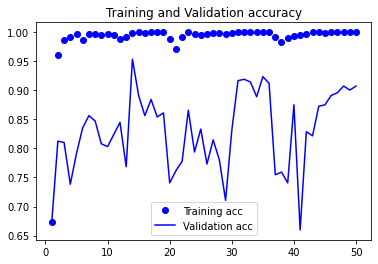

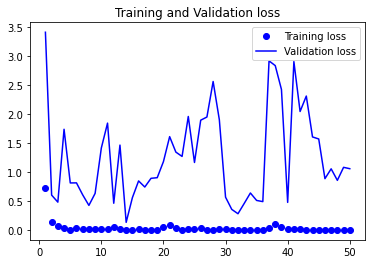




TEST #
=====
axis3 2
Train fold with 1870 images
label
covid      990
healthy    440
others     440
Name: label, dtype: int64

Validation fold with 440 images
label
covid      220
healthy    110
others     110
Name: label, dtype: int64
------------------------------
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_160 (Conv2D)          (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_160 (MaxPoolin (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_161 (Conv2D)          (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_161 (MaxPoolin (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_162 (Conv2D)          (None, 46, 46, 128

116/116 [==============================] - 20s 171ms/step - loss: 1.5724e-04 - accuracy: 1.0000 - val_loss: 3.5771 - val_accuracy: 0.7014
Epoch 40/50
116/116 [==============================] - 20s 171ms/step - loss: 0.0102 - accuracy: 0.9973 - val_loss: 4.1883 - val_accuracy: 0.6597
Epoch 41/50
116/116 [==============================] - 20s 171ms/step - loss: 2.6462e-04 - accuracy: 1.0000 - val_loss: 4.3565 - val_accuracy: 0.6667
Epoch 42/50
116/116 [==============================] - 20s 171ms/step - loss: 0.0313 - accuracy: 0.9941 - val_loss: 4.4932 - val_accuracy: 0.5972
Epoch 43/50
116/116 [==============================] - 20s 171ms/step - loss: 3.1239e-04 - accuracy: 1.0000 - val_loss: 4.7029 - val_accuracy: 0.5995
Epoch 44/50
116/116 [==============================] - 20s 171ms/step - loss: 1.4938e-04 - accuracy: 1.0000 - val_loss: 4.3526 - val_accuracy: 0.6505
Epoch 45/50
116/116 [==============================] - 20s 171ms/step - loss: 4.9115e-04 - accuracy: 1.0000 - val_loss: 

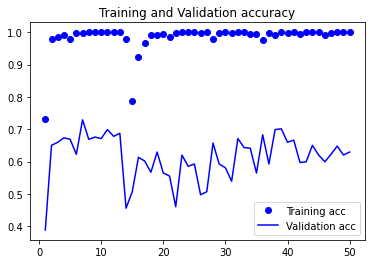

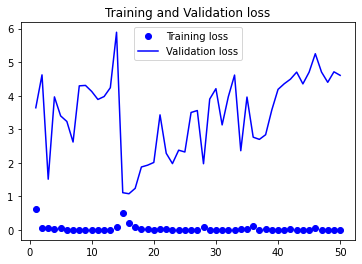




TEST #
=====
axis3 3
Train fold with 1870 images
label
covid      990
healthy    440
others     440
Name: label, dtype: int64

Validation fold with 440 images
label
covid      220
healthy    110
others     110
Name: label, dtype: int64
------------------------------
Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_165 (Conv2D)          (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_165 (MaxPoolin (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_166 (Conv2D)          (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_166 (MaxPoolin (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_167 (Conv2D)          (None, 46, 46, 128

Epoch 39/50
116/116 [==============================] - 20s 171ms/step - loss: 0.0786 - accuracy: 0.9844 - val_loss: 1.4501 - val_accuracy: 0.7245
Epoch 40/50
116/116 [==============================] - 20s 171ms/step - loss: 0.0449 - accuracy: 0.9892 - val_loss: 2.3589e-04 - val_accuracy: 1.0000
Epoch 41/50
116/116 [==============================] - 20s 170ms/step - loss: 1.6215e-04 - accuracy: 1.0000 - val_loss: 0.0150 - val_accuracy: 0.9954
Epoch 42/50
116/116 [==============================] - 20s 171ms/step - loss: 2.8711e-05 - accuracy: 1.0000 - val_loss: 0.0099 - val_accuracy: 0.9977
Epoch 43/50
116/116 [==============================] - 20s 171ms/step - loss: 3.8589e-05 - accuracy: 1.0000 - val_loss: 0.0168 - val_accuracy: 0.9954
Epoch 44/50
116/116 [==============================] - 20s 171ms/step - loss: 8.8176e-06 - accuracy: 1.0000 - val_loss: 0.0262 - val_accuracy: 0.9907
Epoch 45/50
116/116 [==============================] - 20s 171ms/step - loss: 2.8650e-06 - accuracy: 1.0

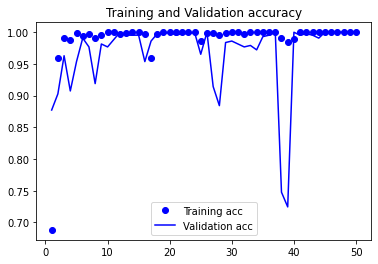

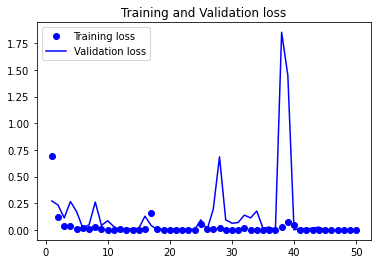




TEST #
=====
axis3 4
Train fold with 1870 images
label
covid      990
healthy    440
others     440
Name: label, dtype: int64

Validation fold with 440 images
label
covid      220
healthy    110
others     110
Name: label, dtype: int64
------------------------------
Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_170 (Conv2D)          (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_170 (MaxPoolin (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_171 (Conv2D)          (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_171 (MaxPoolin (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_172 (Conv2D)          (None, 46, 46, 128

Epoch 39/50
116/116 [==============================] - 20s 171ms/step - loss: 8.5564e-06 - accuracy: 1.0000 - val_loss: 1.7177 - val_accuracy: 0.7870
Epoch 40/50
116/116 [==============================] - 20s 171ms/step - loss: 0.1900 - accuracy: 0.9606 - val_loss: 1.0910 - val_accuracy: 0.6319
Epoch 41/50
116/116 [==============================] - 20s 171ms/step - loss: 0.0253 - accuracy: 0.9941 - val_loss: 2.1429 - val_accuracy: 0.7546
Epoch 42/50
116/116 [==============================] - 20s 171ms/step - loss: 9.9402e-05 - accuracy: 1.0000 - val_loss: 2.4396 - val_accuracy: 0.7477
Epoch 43/50
116/116 [==============================] - 20s 171ms/step - loss: 3.8849e-05 - accuracy: 1.0000 - val_loss: 2.5810 - val_accuracy: 0.7523
Epoch 44/50
116/116 [==============================] - 20s 171ms/step - loss: 1.0968e-04 - accuracy: 1.0000 - val_loss: 2.1418 - val_accuracy: 0.7523
Epoch 45/50
116/116 [==============================] - 20s 171ms/step - loss: 1.1159e-04 - accuracy: 1.0000 

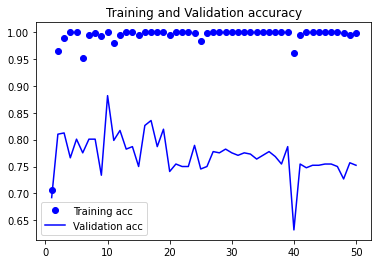

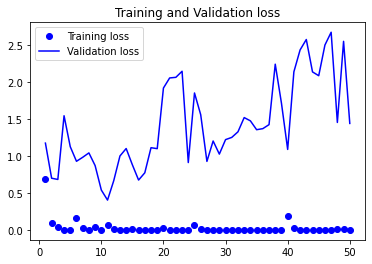




TEST #
=====
axis4 0
Train fold with 1870 images
label
covid      990
healthy    440
others     440
Name: label, dtype: int64

Validation fold with 440 images
label
covid      220
healthy    110
others     110
Name: label, dtype: int64
------------------------------
Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_175 (Conv2D)          (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_175 (MaxPoolin (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_176 (Conv2D)          (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_176 (MaxPoolin (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_177 (Conv2D)          (None, 46, 46, 128

Epoch 39/50
116/116 [==============================] - 20s 176ms/step - loss: 6.9895e-04 - accuracy: 1.0000 - val_loss: 5.2222 - val_accuracy: 0.6250
Epoch 40/50
116/116 [==============================] - 20s 176ms/step - loss: 1.8088e-05 - accuracy: 1.0000 - val_loss: 5.5577 - val_accuracy: 0.6134
Epoch 41/50
116/116 [==============================] - 20s 176ms/step - loss: 7.3540e-05 - accuracy: 1.0000 - val_loss: 5.0255 - val_accuracy: 0.6319
Epoch 42/50
116/116 [==============================] - 20s 176ms/step - loss: 5.1731e-05 - accuracy: 1.0000 - val_loss: 5.0235 - val_accuracy: 0.6667
Epoch 43/50
116/116 [==============================] - 20s 177ms/step - loss: 5.1267e-06 - accuracy: 1.0000 - val_loss: 5.2706 - val_accuracy: 0.6481
Epoch 44/50
116/116 [==============================] - 20s 177ms/step - loss: 8.7945e-04 - accuracy: 0.9995 - val_loss: 4.6514 - val_accuracy: 0.6898
Epoch 45/50
116/116 [==============================] - 21s 177ms/step - loss: 1.8395e-05 - accuracy:

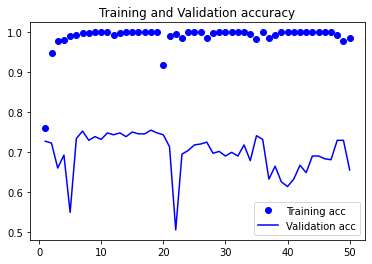

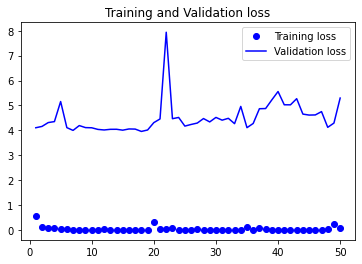




TEST #
=====
axis4 1
Train fold with 1870 images
label
covid      990
healthy    440
others     440
Name: label, dtype: int64

Validation fold with 440 images
label
covid      220
healthy    110
others     110
Name: label, dtype: int64
------------------------------
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_180 (Conv2D)          (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_180 (MaxPoolin (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_181 (Conv2D)          (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_181 (MaxPoolin (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_182 (Conv2D)          (None, 46, 46, 128

Epoch 39/50
116/116 [==============================] - 20s 176ms/step - loss: 0.0334 - accuracy: 0.9957 - val_loss: 6.5240 - val_accuracy: 0.4838
Epoch 40/50
116/116 [==============================] - 20s 176ms/step - loss: 1.7664e-05 - accuracy: 1.0000 - val_loss: 6.0342 - val_accuracy: 0.5116
Epoch 41/50
116/116 [==============================] - 20s 177ms/step - loss: 6.3065e-07 - accuracy: 1.0000 - val_loss: 5.7052 - val_accuracy: 0.4977
Epoch 42/50
116/116 [==============================] - 20s 176ms/step - loss: 2.8122e-06 - accuracy: 1.0000 - val_loss: 5.7559 - val_accuracy: 0.5023
Epoch 43/50
116/116 [==============================] - 20s 177ms/step - loss: 3.8008e-07 - accuracy: 1.0000 - val_loss: 6.0684 - val_accuracy: 0.5046
Epoch 44/50
116/116 [==============================] - 20s 176ms/step - loss: 6.2220e-07 - accuracy: 1.0000 - val_loss: 5.6434 - val_accuracy: 0.5069
Epoch 45/50
116/116 [==============================] - 20s 176ms/step - loss: 7.1301e-07 - accuracy: 1.0

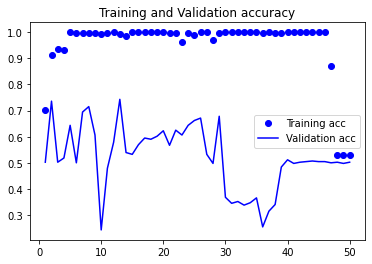

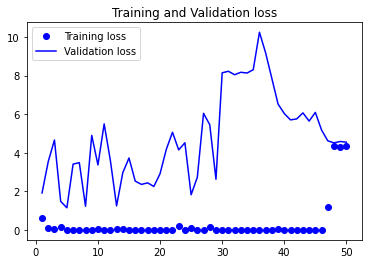




TEST #
=====
axis4 2
Train fold with 1870 images
label
covid      990
healthy    440
others     440
Name: label, dtype: int64

Validation fold with 440 images
label
covid      220
healthy    110
others     110
Name: label, dtype: int64
------------------------------
Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_185 (Conv2D)          (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_185 (MaxPoolin (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_186 (Conv2D)          (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_186 (MaxPoolin (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_187 (Conv2D)          (None, 46, 46, 128

Epoch 39/50
116/116 [==============================] - 20s 176ms/step - loss: 0.0369 - accuracy: 0.9924 - val_loss: 3.5052 - val_accuracy: 0.7546
Epoch 40/50
116/116 [==============================] - 20s 176ms/step - loss: 0.0017 - accuracy: 0.9995 - val_loss: 2.8989 - val_accuracy: 0.7569
Epoch 41/50
116/116 [==============================] - 21s 177ms/step - loss: 0.0151 - accuracy: 0.9973 - val_loss: 3.7461 - val_accuracy: 0.7500
Epoch 42/50
116/116 [==============================] - 20s 176ms/step - loss: 0.0161 - accuracy: 0.9973 - val_loss: 5.6745 - val_accuracy: 0.5833
Epoch 43/50
116/116 [==============================] - 20s 176ms/step - loss: 0.0104 - accuracy: 0.9989 - val_loss: 4.0569 - val_accuracy: 0.7361
Epoch 44/50
116/116 [==============================] - 20s 176ms/step - loss: 1.0842e-04 - accuracy: 1.0000 - val_loss: 4.0233 - val_accuracy: 0.7477
Epoch 45/50
116/116 [==============================] - 20s 176ms/step - loss: 1.7830e-05 - accuracy: 1.0000 - val_loss: 

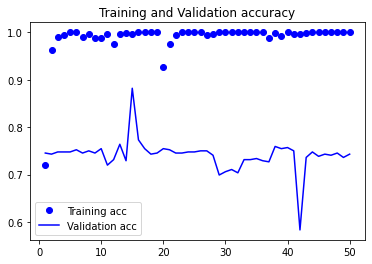

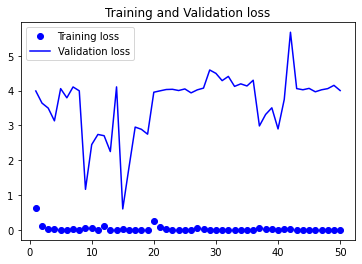




TEST #
=====
axis4 3
Train fold with 1870 images
label
covid      990
healthy    440
others     440
Name: label, dtype: int64

Validation fold with 440 images
label
covid      220
healthy    110
others     110
Name: label, dtype: int64
------------------------------
Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_190 (Conv2D)          (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_190 (MaxPoolin (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_191 (Conv2D)          (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_191 (MaxPoolin (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_192 (Conv2D)          (None, 46, 46, 128

Epoch 39/50
116/116 [==============================] - 20s 176ms/step - loss: 4.3238e-05 - accuracy: 1.0000 - val_loss: 0.2628 - val_accuracy: 0.9630
Epoch 40/50
116/116 [==============================] - 20s 177ms/step - loss: 0.0030 - accuracy: 0.9989 - val_loss: 0.3287 - val_accuracy: 0.9699
Epoch 41/50
116/116 [==============================] - 20s 177ms/step - loss: 0.2581 - accuracy: 0.9590 - val_loss: 0.0470 - val_accuracy: 0.9838
Epoch 42/50
116/116 [==============================] - 20s 176ms/step - loss: 0.0744 - accuracy: 0.9838 - val_loss: 0.8876 - val_accuracy: 0.8889
Epoch 43/50
116/116 [==============================] - 20s 176ms/step - loss: 0.0061 - accuracy: 0.9984 - val_loss: 0.1889 - val_accuracy: 0.9722
Epoch 44/50
116/116 [==============================] - 21s 177ms/step - loss: 2.6058e-04 - accuracy: 1.0000 - val_loss: 0.1547 - val_accuracy: 0.9722
Epoch 45/50
116/116 [==============================] - 21s 177ms/step - loss: 0.0089 - accuracy: 0.9978 - val_loss: 

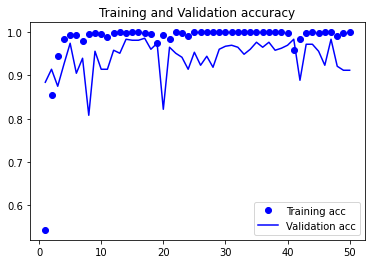

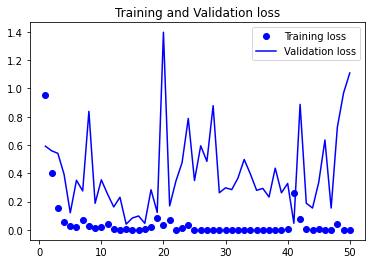




TEST #
=====
axis4 4
Train fold with 1870 images
label
covid      990
healthy    440
others     440
Name: label, dtype: int64

Validation fold with 440 images
label
covid      220
healthy    110
others     110
Name: label, dtype: int64
------------------------------
Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_195 (Conv2D)          (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_195 (MaxPoolin (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_196 (Conv2D)          (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_196 (MaxPoolin (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_197 (Conv2D)          (None, 46, 46, 128

Epoch 39/50
116/116 [==============================] - 20s 176ms/step - loss: 9.0777e-07 - accuracy: 1.0000 - val_loss: 4.6920 - val_accuracy: 0.6597
Epoch 40/50
116/116 [==============================] - 20s 176ms/step - loss: 0.0188 - accuracy: 0.9924 - val_loss: 2.0265 - val_accuracy: 0.6667
Epoch 41/50
116/116 [==============================] - 20s 176ms/step - loss: 0.1161 - accuracy: 0.9784 - val_loss: 3.6094 - val_accuracy: 0.7431
Epoch 42/50
116/116 [==============================] - 20s 176ms/step - loss: 0.1064 - accuracy: 0.9827 - val_loss: 2.1335 - val_accuracy: 0.7315
Epoch 43/50
116/116 [==============================] - 20s 176ms/step - loss: 0.0382 - accuracy: 0.9908 - val_loss: 3.6960 - val_accuracy: 0.7130
Epoch 44/50
116/116 [==============================] - 20s 176ms/step - loss: 1.8449e-05 - accuracy: 1.0000 - val_loss: 4.1274 - val_accuracy: 0.7176
Epoch 45/50
116/116 [==============================] - 20s 176ms/step - loss: 5.6316e-06 - accuracy: 1.0000 - val_lo

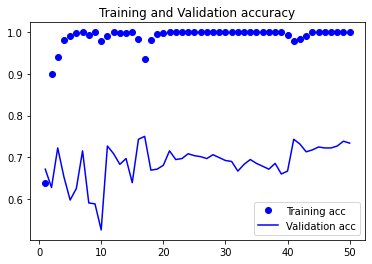

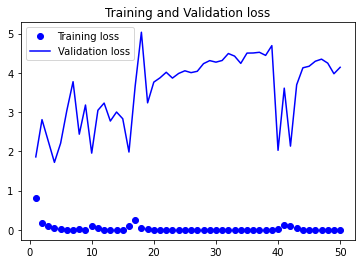

In [43]:
for cur_subfolder in SUB_FILE:
    for set_number in [0, 1, 2, 3, 4]:
        print('\n\n\nTEST #\n=====')
        print(cur_subfolder, set_number)
        train_df, validation_df = get_data_set(set_number, cur_subfolder)
        model, SELECTED_MODEL = get_model()
        history = train_model(model, train_df, validation_df, EPOCHS)
        plot_results(history, cur_subfolder, str(set_number), SELECTED_MODEL)

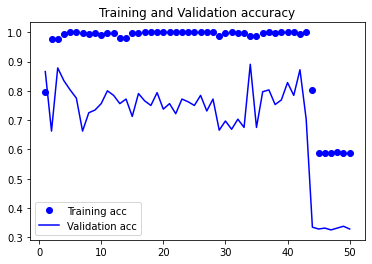

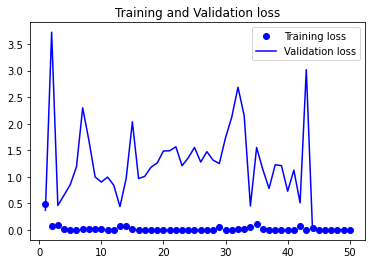